In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

# Time series modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation metrics
from sklearn.metrics import mean_squared_error

# Ignore warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv('Walmart.csv')

# Parse date column
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [5]:
# Aggregate sales per week across all stores
df_weekly = df.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'Holiday_Flag': 'max',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
}).sort_index()

# Set frequency to weekly (Friday)
df_weekly = df_weekly.asfreq('W-FRI')

# Prepare exogenous variables
exog_vars = ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
exog = df_weekly[exog_vars]

df_weekly.head()


,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-02-05,49750740.50,0,34.037333,2.717844,167.730885,8.619311
2010-02-12,48336677.63,1,34.151333,2.694022,167.825608,8.619311
2010-02-19,48276993.78,0,37.719778,2.672067,167.871686,8.619311
2010-02-26,43968571.13,0,39.243556,2.683933,167.909657,8.619311
2010-03-05,46871470.30,0,42.917333,2.731200,167.947628,8.619311


In [6]:
# Train/test split (last 26 weeks for testing)
train = df_weekly.iloc[:-26]
test = df_weekly.iloc[-26:]

exog_train = exog.iloc[:-26]
exog_test = exog.iloc[-26:]

print(f'Train period: {train.index[0]} to {train.index[-1]}')
print(f'Test period: {test.index[0]} to {test.index[-1]}')


Train period: 2010-02-05 00:00:00 to 2012-04-27 00:00:00
Test period: 2012-05-04 00:00:00 to 2012-10-26 00:00:00


In [7]:
# Define SARIMAX parameter grid
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 52  # Seasonal period (weekly data, yearly seasonality)

parameters = list(itertools.product(p, d, q, P, D, Q))
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

print("Starting SARIMAX grid search...")

for param in parameters:
    order = (param[0], param[1], param[2])
    seasonal_order = (param[3], param[4], param[5], s)
    try:
        model = SARIMAX(train['Weekly_Sales'],
                        exog=exog_train,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_seasonal_order = seasonal_order
            best_model = results
        print(f"Tested SARIMAX{order}x{seasonal_order} - AIC:{results.aic:.2f}")
    except Exception as e:
        print(f"Failed SARIMAX{order}x{seasonal_order}: {e}")

print("\nBest SARIMAX order:", best_order)
print("Best seasonal order:", best_seasonal_order)
print("Best AIC:", best_aic)


Starting SARIMAX grid search...
Tested SARIMAX(0, 0, 0)x(0, 0, 0, 52) - AIC:4389.87
Tested SARIMAX(0, 0, 0)x(0, 0, 1, 52) - AIC:2130.63
Tested SARIMAX(0, 0, 0)x(0, 1, 0, 52) - AIC:2253.45
Tested SARIMAX(0, 0, 0)x(0, 1, 1, 52) - AIC:402.79
Tested SARIMAX(0, 0, 0)x(1, 0, 0, 52) - AIC:2070.97
Tested SARIMAX(0, 0, 0)x(1, 0, 1, 52) - AIC:2131.61
Tested SARIMAX(0, 0, 0)x(1, 1, 0, 52) - AIC:432.49
Tested SARIMAX(0, 0, 0)x(1, 1, 1, 52) - AIC:400.94
Tested SARIMAX(0, 0, 1)x(0, 0, 0, 52) - AIC:3915.31
Tested SARIMAX(0, 0, 1)x(0, 0, 1, 52) - AIC:2097.57
Tested SARIMAX(0, 0, 1)x(0, 1, 0, 52) - AIC:2016.19
Tested SARIMAX(0, 0, 1)x(0, 1, 1, 52) - AIC:373.05
Tested SARIMAX(0, 0, 1)x(1, 0, 0, 52) - AIC:2162.86
Tested SARIMAX(0, 0, 1)x(1, 0, 1, 52) - AIC:2098.88
Tested SARIMAX(0, 0, 1)x(1, 1, 0, 52) - AIC:430.78
Tested SARIMAX(0, 0, 1)x(1, 1, 1, 52) - AIC:370.30
Tested SARIMAX(0, 1, 0)x(0, 0, 0, 52) - AIC:4388.62
Tested SARIMAX(0, 1, 0)x(0, 0, 1, 52) - AIC:2119.59
Tested SARIMAX(0, 1, 0)x(0, 1, 0, 52) 

In [8]:
# Forecast using the best model
forecast = best_model.get_forecast(steps=len(test), exog=exog_test)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Weekly_Sales'], pred))
mean_actual = test['Weekly_Sales'].mean()
rmse_percent = (rmse / mean_actual) * 100

print(f'RMSE on test set: {rmse:,.2f}')
print(f'RMSE (% of mean actual sales): {rmse_percent:.2f}%')


RMSE on test set: 1,689,825.37
RMSE (% of mean actual sales): 3.60%


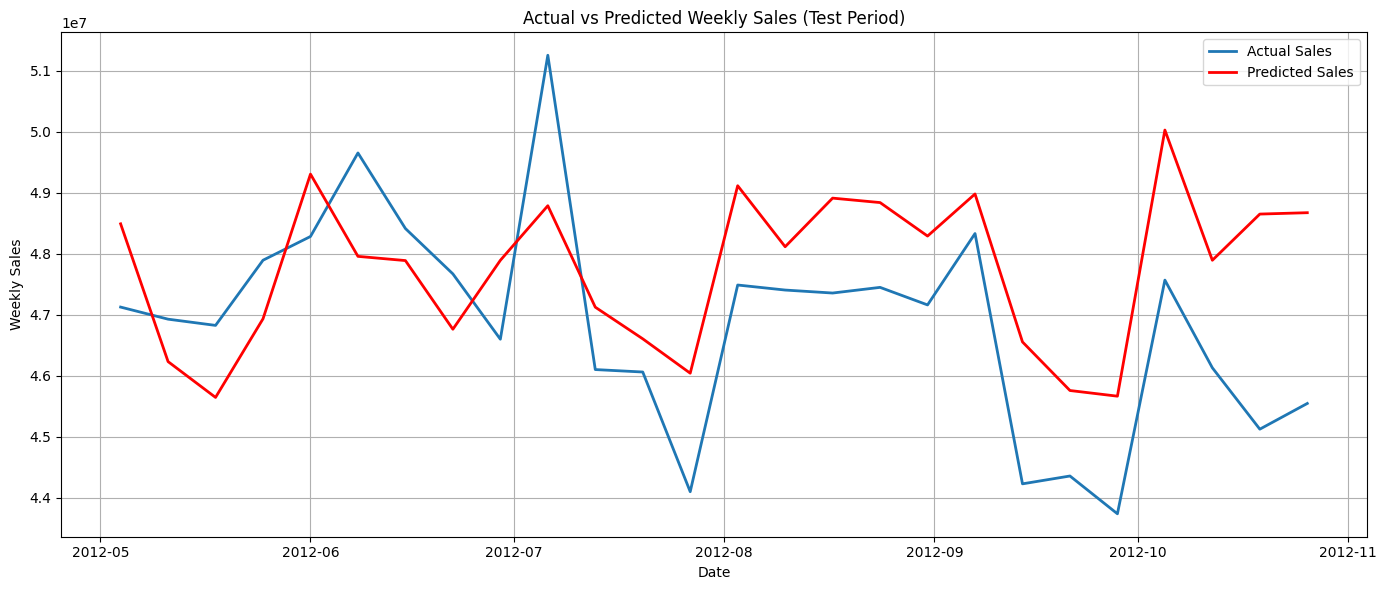

In [17]:
plt.figure(figsize=(14, 6))  # Adjust plot size as needed

# Plot actual and predicted sales without markers
plt.plot(test.index, test['Weekly_Sales'], label='Actual Sales', linewidth=2)
plt.plot(test.index, pred, label='Predicted Sales', color='red', linewidth=2)

plt.title('Actual vs Predicted Weekly Sales (Test Period)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Extract the coefficients (params) of exogenous variables
exog_coefs = best_model.params[best_model.model.exog_names]

# Convert to dataframe for plotting
import pandas as pd
feature_importance = pd.DataFrame({'Feature': exog_coefs.index, 'Coefficient': exog_coefs.values})

# Take absolute value to show magnitude
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()

# Sort by absolute value
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)


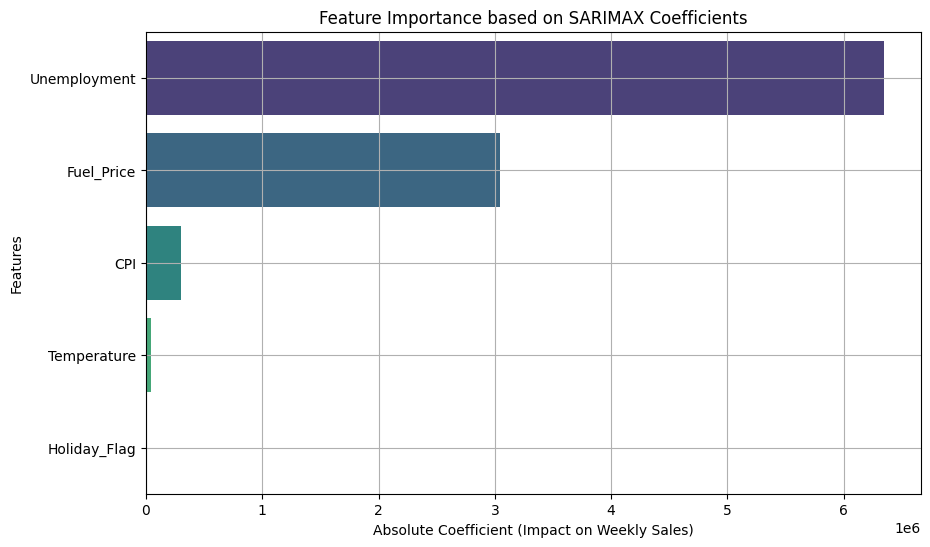

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Abs_Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance based on SARIMAX Coefficients')
plt.xlabel('Absolute Coefficient (Impact on Weekly Sales)')
plt.ylabel('Features')
plt.grid(True)
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error

train_pred = best_model.fittedvalues
train_rmse = np.sqrt(mean_squared_error(train['Weekly_Sales'], train_pred))
print(f'Training RMSE: {train_rmse:,.2f}')


Training RMSE: 75,768,668.86


In [24]:
# Create a list of unique stores
stores = df['Store'].unique()

# Create a dictionary to hold store-level data
store_data = {}

for store in stores:
    df_store = df[df['Store'] == store].groupby('Date').agg({
        'Weekly_Sales': 'sum',
        'Holiday_Flag': 'max',
        'Temperature': 'mean',
        'Fuel_Price': 'mean',
        'CPI': 'mean',
        'Unemployment': 'mean'
    }).sort_index()
    
    df_store = df_store.asfreq('W-FRI')
    
    store_data[store] = df_store


In [25]:
results_dict = {}

for store, data in store_data.items():
    print(f"\nTraining model for Store {store}...")
    
    exog_vars = ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    exog = data[exog_vars]

    train = data.iloc[:-26]
    test = data.iloc[-26:]
    
    exog_train = exog.iloc[:-26]
    exog_test = exog.iloc[-26:]
    
    try:
        model = SARIMAX(train['Weekly_Sales'],
                        exog=exog_train,
                        order=(1, 1, 1),  # Use best parameters or search per store
                        seasonal_order=(1, 1, 1, 52),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        
        forecast = results.get_forecast(steps=len(test), exog=exog_test)
        pred = forecast.predicted_mean
        rmse = np.sqrt(mean_squared_error(test['Weekly_Sales'], pred))
        
        results_dict[store] = {'model': results, 'rmse': rmse, 'forecast': forecast}
        
        print(f"Store {store} RMSE: {rmse:.2f}")
    
    except Exception as e:
        print(f"Failed for Store {store}: {e}")



Training model for Store 1...
Store 1 RMSE: 116381.00

Training model for Store 2...
Store 2 RMSE: 70708.20

Training model for Store 3...
Store 3 RMSE: 29588.18

Training model for Store 4...
Store 4 RMSE: 86926.09

Training model for Store 5...
Store 5 RMSE: 20622.27

Training model for Store 6...
Store 6 RMSE: 96525.26

Training model for Store 7...
Store 7 RMSE: 27731.62

Training model for Store 8...
Store 8 RMSE: 42323.57

Training model for Store 9...
Store 9 RMSE: 31356.04

Training model for Store 10...
Store 10 RMSE: 96349.08

Training model for Store 11...
Store 11 RMSE: 61565.95

Training model for Store 12...
Store 12 RMSE: 37704.17

Training model for Store 13...
Store 13 RMSE: 94616.90

Training model for Store 14...
Store 14 RMSE: 153426.39

Training model for Store 15...
Store 15 RMSE: 50459.46

Training model for Store 16...
Store 16 RMSE: 31680.89

Training model for Store 17...
Store 17 RMSE: 35243.95

Training model for Store 18...
Store 18 RMSE: 67898.49

Trainin

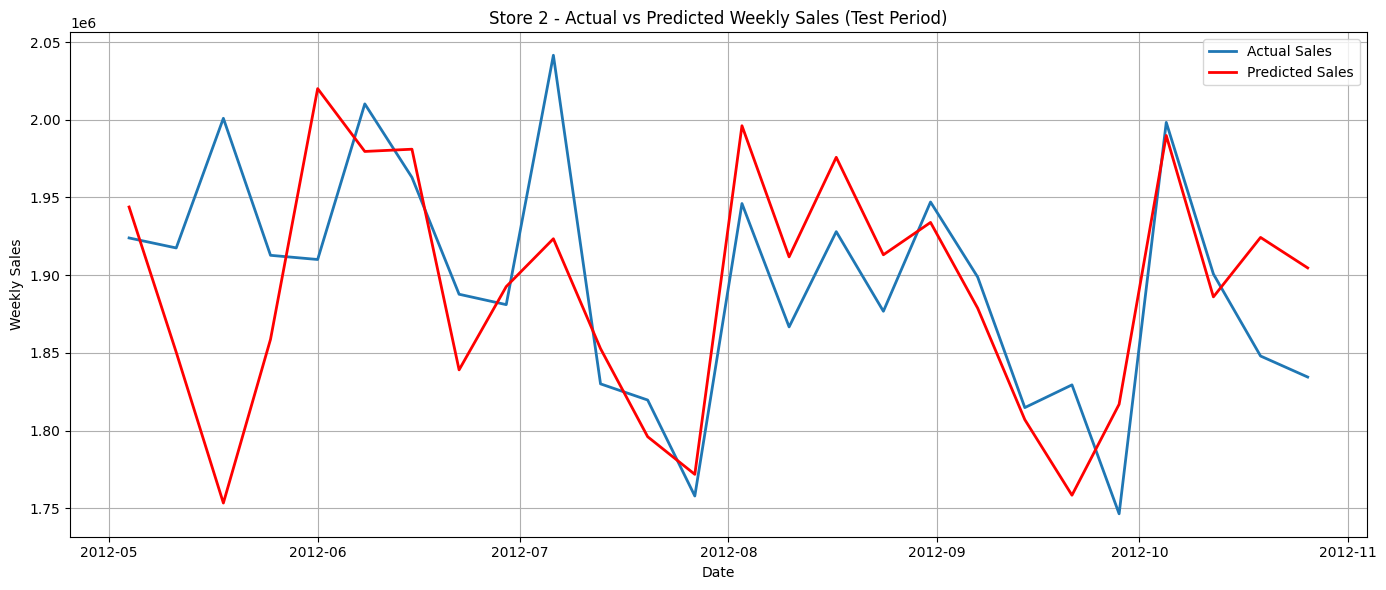

In [27]:
store_to_plot = 2  # Example: Store 1

# Get test data and predictions for the selected store
test = store_data[store_to_plot].iloc[-26:]
pred = results_dict[store_to_plot]['forecast'].predicted_mean

plt.figure(figsize=(14,6))

# Plot only actual vs predicted
plt.plot(test.index, test['Weekly_Sales'], label='Actual Sales', linewidth=2)
plt.plot(test.index, pred, label='Predicted Sales', color='red', linewidth=2)

plt.title(f'Store {store_to_plot} - Actual vs Predicted Weekly Sales (Test Period)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error
import numpy as np

store_rmse_percent = {}

for store, data in store_data.items():
    test = data.iloc[-26:]
    pred = results_dict[store]['forecast'].predicted_mean

    rmse = np.sqrt(mean_squared_error(test['Weekly_Sales'], pred))
    mean_actual = test['Weekly_Sales'].mean()
    rmse_percent = (rmse / mean_actual) * 100

    store_rmse_percent[store] = rmse_percent

    print(f'Store {store} RMSE: {rmse:,.2f} ({rmse_percent:.2f}% of mean actual sales)')


Store 1 RMSE: 116,381.00 (7.39% of mean actual sales)
Store 2 RMSE: 70,708.20 (3.73% of mean actual sales)
Store 3 RMSE: 29,588.18 (7.09% of mean actual sales)
Store 4 RMSE: 86,926.09 (4.03% of mean actual sales)
Store 5 RMSE: 20,622.27 (6.29% of mean actual sales)
Store 6 RMSE: 96,525.26 (6.20% of mean actual sales)
Store 7 RMSE: 27,731.62 (4.65% of mean actual sales)
Store 8 RMSE: 42,323.57 (4.65% of mean actual sales)
Store 9 RMSE: 31,356.04 (5.66% of mean actual sales)
Store 10 RMSE: 96,349.08 (5.43% of mean actual sales)
Store 11 RMSE: 61,565.95 (4.59% of mean actual sales)
Store 12 RMSE: 37,704.17 (3.84% of mean actual sales)
Store 13 RMSE: 94,616.90 (4.62% of mean actual sales)
Store 14 RMSE: 153,426.39 (8.86% of mean actual sales)
Store 15 RMSE: 50,459.46 (8.45% of mean actual sales)
Store 16 RMSE: 31,680.89 (5.92% of mean actual sales)
Store 17 RMSE: 35,243.95 (3.68% of mean actual sales)
Store 18 RMSE: 67,898.49 (6.41% of mean actual sales)
Store 19 RMSE: 109,240.62 (7.79% of

In [34]:
all_actual = []
all_predicted = []

for store, data in store_data.items():
    test = data.iloc[-26:]
    pred = results_dict[store]['forecast'].predicted_mean

    all_actual.extend(test['Weekly_Sales'].values)
    all_predicted.extend(pred.values)

# Calculate overall RMSE
overall_rmse = np.sqrt(mean_squared_error(all_actual, all_predicted))
print(f'Overall Total RMSE: {overall_rmse:,.2f}')


Overall Total RMSE: 74,925.41


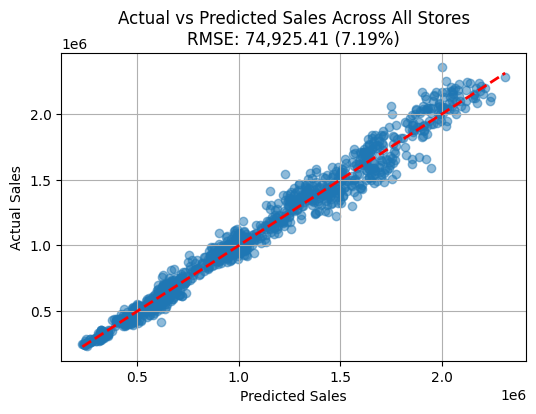

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

actual_all = []
predicted_all = []

# Collect actual and predicted sales for all stores
for store, data in store_data.items():
    test = data.iloc[-26:]
    pred = results_dict[store]['forecast'].predicted_mean

    actual_all.extend(test['Weekly_Sales'].values)
    predicted_all.extend(pred.values)

# Calculate overall RMSE
overall_rmse = np.sqrt(mean_squared_error(actual_all, predicted_all))
rmse_percent = (overall_rmse / np.mean(actual_all)) * 100

# Scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(predicted_all, actual_all, alpha=0.5)
plt.plot([min(predicted_all), max(predicted_all)], [min(predicted_all), max(predicted_all)], 'r--', linewidth=2)

plt.title(f'Actual vs Predicted Sales Across All Stores\nRMSE: {overall_rmse:,.2f} ({rmse_percent:.2f}%)')
plt.xlabel('Predicted Sales')
plt.ylabel('Actual Sales')
plt.grid(True)
plt.show()
